In [1]:
import numpy as np
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import cv2
import pandas as pd
from imutils import paths

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt

rs = 42
def reset_random_seeds(rs):
   os.environ['PYTHONHASHSEED']=str(rs)
   tf.random.set_seed(rs)
   np.random.seed(rs)
   random.seed(rs)
reset_random_seeds(rs)

# Part 1 - Data Preprocessing

In [2]:
header_list = ['collaborative_value','computer_value','predictable_value','selfishly_value','wisely_value']
rate_vectors = pd.read_csv('./data/humanModel/dataset_v0/participants_rate.csv', names=header_list)

In [3]:
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = list(paths.list_images('./data/humanModel/dataset_v0/'))

# initialize the data
data = []
actionLabels = []
rate_vector_value = []

batch_size = 64
IMG_SIZE = 5

# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	# image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = img_to_array(image)
	data.append(image)
	# extract the action and rate from the path and
	# update the respective lists
	split_path = imagePath.split(os.path.sep)
	action = split_path[-2]
	actionLabels.append(action)
	index = int(split_path[-1].split("_")[-1].split(".")[0])
	value_rate = rate_vectors.iloc[index].tolist()
	rate_vector_value.append(value_rate)

[INFO] loading images...


In [4]:
action

'38'

## Split into train , test data

In [5]:
# scale the raw pixel intensities to the range [0, 1] and convert to
# a NumPy array
data = np.array(data, dtype="float") / 255.0
print("[INFO] data matrix: {} images ({:.2f}MB)".format(
	len(data), data.nbytes / (1024 * 1000.0)))
# convert the label lists to NumPy arrays prior to binarization
actionLabels = np.array(actionLabels)
rate_vector_value = np.array(rate_vector_value) / 7
# binarize both sets of labels
print("[INFO] binarizing labels...")
actionLB = LabelBinarizer()
actionLabels = actionLB.fit_transform(actionLabels)

# partition the data into training and testing splits using 80% of
split = train_test_split(data, actionLabels, rate_vector_value, test_size=0.2, random_state=rs, shuffle=True)
(trainX, testX, trainActionY, testActionY, trainRateY, testRateY) = split

[INFO] data matrix: 8160 images (4.78MB)
[INFO] binarizing labels...


In [6]:
rate_vector_value

array([[0.57142857, 1.        , 0.85714286, 0.14285714, 0.57142857],
       [0.57142857, 1.        , 0.85714286, 0.14285714, 0.57142857],
       [0.57142857, 1.        , 0.85714286, 0.14285714, 0.57142857],
       ...,
       [0.57142857, 1.        , 0.85714286, 0.14285714, 0.57142857],
       [0.57142857, 1.        , 0.85714286, 0.14285714, 0.57142857],
       [0.57142857, 1.        , 0.85714286, 0.14285714, 0.57142857]])

In [7]:
ACTION_NUM = 4
RATE_VECTOR_LEN = 5

# Define model layers.
input_layer = Input(shape=(IMG_SIZE,IMG_SIZE,3))
X = Conv2D(4, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
X = Conv2D(8, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
X = Conv2D(8, 2, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)
X = Dropout(0.5)(X)
X = Flatten()(X)
X = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(X)

# action output will be fed from the first dense
action_output = Dense(ACTION_NUM, activation='softmax', name='action_output')(X)
rate_output = Dense(RATE_VECTOR_LEN, activation='linear', name='rate_output')(X)

# Define the model with the input layer 
# and a list of output layers
model = Model(inputs=input_layer,outputs=[action_output, rate_output])

In [8]:
EPOCHS = 175
INIT_LR = 1e-3

losses = {
	"action_output": "categorical_crossentropy",
	"rate_output": "mse"
}
lossWeights = {"action_output": 0.5, "rate_output": 0.5}

# initialize the optimizer and compile the model
print("[INFO] compiling model...")

opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer='adam', loss=losses, loss_weights=lossWeights,
	metrics=["accuracy"])

[INFO] compiling model...


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 5, 3)]    0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 5, 5, 4)      112         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 5, 8)      296         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 5, 5, 8)      264         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
# train the network to perform multi-output
history = model.fit(x=trainX, y={"action_output": trainActionY, "rate_output": trainRateY},
	validation_data=(testX, {"action_output": testActionY, "rate_output": testRateY}),
	epochs=EPOCHS)

Epoch 1/175
204/204 [==============================] - 2s 3ms/step - loss: 0.7844 - action_output_loss: 1.3832 - rate_output_loss: 0.0492 - action_output_accuracy: 0.2744 - rate_output_accuracy: 0.8964 - val_loss: 0.7315 - val_action_output_loss: 1.3723 - val_rate_output_loss: 0.0046 - val_action_output_accuracy: 0.3162 - val_rate_output_accuracy: 0.9835
Epoch 2/175
204/204 [==============================] - 0s 2ms/step - loss: 0.7062 - action_output_loss: 1.3338 - rate_output_loss: 0.0087 - action_output_accuracy: 0.3523 - rate_output_accuracy: 0.9681 - val_loss: 0.6768 - val_action_output_loss: 1.2885 - val_rate_output_loss: 0.0036 - val_action_output_accuracy: 0.3860 - val_rate_output_accuracy: 0.9835
Epoch 3/175
204/204 [==============================] - 0s 2ms/step - loss: 0.6567 - action_output_loss: 1.2522 - rate_output_loss: 0.0061 - action_output_accuracy: 0.4341 - rate_output_accuracy: 0.9804 - val_loss: 0.6398 - val_action_output_loss: 1.2269 - val_rate_output_loss: 0.0021 -

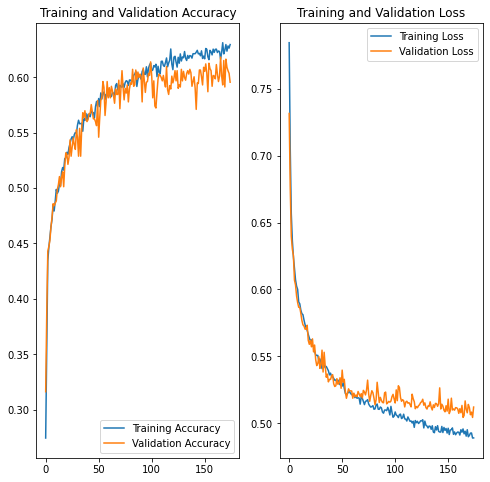

In [11]:
acc = history.history['action_output_accuracy']
val_acc = history.history['val_action_output_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
_ = model.evaluate(x=testX, y={'action_output': testActionY, 'rate_output': testRateY})

51/51 [==============================] - 0s 1ms/step - loss: 0.5122 - action_output_loss: 0.9336 - rate_output_loss: 8.7152e-04 - action_output_accuracy: 0.5956 - rate_output_accuracy: 0.9835


In [13]:
# Save the weights model.
model.save('./data/humanModel/empathy_model_v0.h5')

In [14]:
# save model in js format
# import tensorflowjs as tfjs
# tfjs.converters.save_keras_model(model, 'data/humanModel/js_model_v0')

In [15]:
# new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# # Check its architecture
# new_model.summary()

### Predict on new data

In [16]:
path = "./data/humanModel_v0_dataset_split/val/38/-Mr4e3Fomo72jz0zfTgB_14.png"

img = keras.preprocessing.image.load_img(
    path, target_size=(IMG_SIZE, IMG_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array = img_array/255
predictions = model.predict(img_array)[0]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(np.argmax(predictions), 100 * np.max(predictions))
)

FileNotFoundError: [Errno 2] No such file or directory: './data/humanModel_v0_dataset_split/val/38/-Mr4e3Fomo72jz0zfTgB_14.png'